![image](https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/notebooks/headers/AutoAI-Banner_Pipeline-Notebook.png)
# Pipeline 6 Notebook - AutoAI Notebook v1.16.3

Consider these tips for working with an auto-generated notebook:
- Notebook code generated using AutoAI will execute successfully. If you modify the notebook, we cannot guarantee it will run successfully.
- This pipeline is optimized for the original data set. The pipeline might fail or produce sub-optimum results if used with different data.  If you want to use a different data set, consider retraining the AutoAI experiment to generate a new pipeline. For more information, see <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/autoai-notebook.html">Cloud Platform</a>. 
- Before modifying the pipeline or trying to re-fit the pipeline, consider that the code converts dataframes to numpy arrays before fitting the pipeline (a current restriction of the preprocessor pipeline).


<a id="content"></a>
## Notebook content

This notebook contains a Scikit-learn representation of AutoAI pipeline. This notebook introduces commands for getting data, training the model, and testing the model. 

Some familiarity with Python is helpful. This notebook uses python 3.9 and scikit-learn 1.0.2.

## Notebook goals

-  Scikit-learn pipeline definition
-  Pipeline training 
-  Pipeline evaluation

## Contents

This notebook contains the following parts:

**[Setup](#setup)**<br>
&nbsp;&nbsp;[Package installation](#install)<br>
&nbsp;&nbsp;[AutoAI experiment metadata](#variables_definition)<br>
&nbsp;&nbsp;[Watson Machine Learning connection](#connection)<br>
**[Pipeline inspection](#inspection)** <br>
&nbsp;&nbsp;[Read training data](#read)<br>
&nbsp;&nbsp;[Train and test data split](#split)<br>
&nbsp;&nbsp;[Make pipeline](#preview_model_to_python_code)<br>
&nbsp;&nbsp;[Train pipeline model](#train)<br>
&nbsp;&nbsp;[Test pipeline model](#test_model)<br>
**[Summary and next steps](#summary_and_next_steps)**<br>
**[Copyrights](#copyrights)**

<a id="setup"></a>
# Setup

<a id="install"></a>
## Package installation
Before you use the sample code in this notebook, install the following packages:
 - ibm_watson_machine_learning,
 - autoai-libs,
 - scikit-learn,
 - lightgbm.


In [1]:
!pip install -U ibm-watson-machine-learning | tail -n 1
!pip install -U autoai-libs==1.13.4 | tail -n 1
!pip install -U scikit-learn==1.0.2 | tail -n 1
!pip install -U lightgbm==3.3.2 | tail -n 1
!pip install -U shap | tail -n 1

<a id="variables_definition"></a>
## AutoAI experiment metadata
The following cell contains the training data connection details.  
**Note**: The connection might contain authorization credentials, so be careful when sharing the notebook.

In [2]:
from ibm_watson_machine_learning.helpers import DataConnection
from ibm_watson_machine_learning.helpers import ContainerLocation

training_data_references = [
    DataConnection(
        data_asset_id='c4c05133-d82c-427b-bd55-6d5e030e305c'
    ),
]
training_result_reference = DataConnection(
    location=ContainerLocation(
        path='auto_ml/92f0cf58-0bac-4fdd-ae85-33dd353da5ae/wml_data/0dd69b8c-2361-4c39-a37f-f46d6e4c7424/data/automl',
        model_location='auto_ml/92f0cf58-0bac-4fdd-ae85-33dd353da5ae/wml_data/0dd69b8c-2361-4c39-a37f-f46d6e4c7424/data/automl/model.zip',
        training_status='auto_ml/92f0cf58-0bac-4fdd-ae85-33dd353da5ae/wml_data/0dd69b8c-2361-4c39-a37f-f46d6e4c7424/training-status.json'
    )
)

Following cell contains input parameters provided to run the AutoAI experiment in Watson Studio.

In [3]:
experiment_metadata = dict(
    prediction_type='regression',
    prediction_column='Prctl in Polish',
    holdout_size=0.1,
    scoring='neg_root_mean_squared_error',
    csv_separator=',',
    random_state=33,
    max_number_of_estimators=2,
    training_data_references=training_data_references,
    training_result_reference=training_result_reference,
    deployment_url='https://eu-de.ml.cloud.ibm.com',
    project_id='a5be98f5-8e87-42f4-8fe9-4bd0b14c6d7a',
    text_processing=False,
    train_sample_columns_index_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    drop_duplicates=True
)

## Set `n_jobs` parameter to the number of available CPUs

In [4]:
import os, ast
CPU_NUMBER = 2
if 'RUNTIME_HARDWARE_SPEC' in os.environ:
    CPU_NUMBER = int(ast.literal_eval(os.environ['RUNTIME_HARDWARE_SPEC'])['num_cpu'])

<a id="connection"></a>
## Watson Machine Learning connection

This cell defines the credentials required to work with the Watson Machine Learning service.

**Action:** Please provide IBM Cloud apikey following [docs](https://cloud.ibm.com/docs/account?topic=account-userapikey).

In [5]:
api_key = '-2Mnuw3ccEHT8Dy1Uev_S3GiJ7vs66eY93G3GaujOabQ'

In [6]:
wml_credentials = {
    "apikey": api_key,
    "url": experiment_metadata['deployment_url']
}

In [7]:
from ibm_watson_machine_learning import APIClient

wml_client = APIClient(wml_credentials)

if 'space_id' in experiment_metadata:
    wml_client.set.default_space(experiment_metadata['space_id'])
else:
    wml_client.set.default_project(experiment_metadata['project_id'])
    
training_data_references[0].set_client(wml_client)



<a id="inspection"></a>
# Pipeline inspection

<a id="read"></a>
## Read training data

Retrieve training dataset from AutoAI experiment as pandas DataFrame.

**Note**: If reading data results in an error, provide data as Pandas DataFrame object, for example, reading .CSV file with `pandas.read_csv()`. It may be necessary to use methods for initial data pre-processing like: e.g. `DataFrame.dropna()`, `DataFrame.drop_duplicates()`, `DataFrame.sample()`.

In [8]:
train_X, test_X, train_y, test_y = training_data_references[0].read(experiment_metadata=experiment_metadata, with_holdout_split=True, use_flight=False)

<a id="preview_model_to_python_code"></a>
## Make pipeline
In the next cell, you can find the Scikit-learn definition of the selected AutoAI pipeline.

#### Import statements.

In [9]:
from autoai_libs.transformers.exportable import ColumnSelector
from autoai_libs.transformers.exportable import NumpyColumnSelector
from autoai_libs.transformers.exportable import CompressStrings
from autoai_libs.transformers.exportable import NumpyReplaceMissingValues
from autoai_libs.transformers.exportable import NumpyReplaceUnknownValues
from autoai_libs.transformers.exportable import boolean2float
from autoai_libs.transformers.exportable import CatImputer
from autoai_libs.transformers.exportable import CatEncoder
import numpy as np
from autoai_libs.transformers.exportable import float32_transform
from sklearn.pipeline import make_pipeline
from autoai_libs.transformers.exportable import FloatStr2Float
from autoai_libs.transformers.exportable import NumImputer
from autoai_libs.transformers.exportable import OptStandardScaler
from sklearn.pipeline import make_union
from autoai_libs.transformers.exportable import NumpyPermuteArray
from lightgbm.sklearn import LGBMRegressor

#### Pre-processing & Estimator.

In [10]:
column_selector_0 = ColumnSelector(
    columns_indices_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
)
numpy_column_selector_0 = NumpyColumnSelector(
    columns=[0, 1, 3, 6, 7, 8, 9, 10]
)
compress_strings = CompressStrings(
    compress_type="hash",
    dtypes_list=[
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
        "float_int_num", "float_int_num", "float_int_num", "float_int_num",
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
    misslist_list=[[], [], [], [], [], [], [], []],
)
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=100001
)
numpy_replace_unknown_values = NumpyReplaceUnknownValues(
    filling_values=100001,
    filling_values_list=[
        100001, 100001, 100001, 100001, 100001, 100001, 100001, 100001,
    ],
    missing_values_reference_list=["", "-", "?", float("nan")],
)
cat_imputer = CatImputer(
    missing_values=100001,
    sklearn_version_family="1",
    strategy="most_frequent",
)
cat_encoder = CatEncoder(
    encoding="ordinal",
    categories="auto",
    dtype=np.float64,
    handle_unknown="error",
    sklearn_version_family="1",
)
pipeline_0 = make_pipeline(
    column_selector_0,
    numpy_column_selector_0,
    compress_strings,
    numpy_replace_missing_values_0,
    numpy_replace_unknown_values,
    boolean2float(),
    cat_imputer,
    cat_encoder,
    float32_transform(),
)
column_selector_1 = ColumnSelector(
    columns_indices_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
)
numpy_column_selector_1 = NumpyColumnSelector(columns=[2, 4, 5, 11])
float_str2_float = FloatStr2Float(
    dtypes_list=["float_num", "float_num", "float_num", "float_num"],
    missing_values_reference_list=[],
)
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(
    missing_values=[], filling_values=float("nan")
)
num_imputer = NumImputer(missing_values=float("nan"), strategy="median")
opt_standard_scaler = OptStandardScaler(use_scaler_flag=False)
pipeline_1 = make_pipeline(
    column_selector_1,
    numpy_column_selector_1,
    float_str2_float,
    numpy_replace_missing_values_1,
    num_imputer,
    opt_standard_scaler,
    float32_transform(),
)
union = make_union(pipeline_0, pipeline_1)
numpy_permute_array = NumpyPermuteArray(
    axis=0, permutation_indices=[0, 1, 3, 6, 7, 8, 9, 10, 2, 4, 5, 11]
)
lgbm_regressor = LGBMRegressor(
    class_weight="balanced",
    colsample_bytree=0.8409625304190137,
    learning_rate=0.05456992609360918,
    min_child_samples=7,
    min_child_weight=0.008145904258338813,
    n_estimators=129,
    n_jobs=CPU_NUMBER,
    num_leaves=8,
    random_state=33,
    reg_alpha=0.7172220528767622,
    reg_lambda=0.17539193704680456,
    subsample=0.29604768512610175,
    subsample_freq=2,
)


#### Pipeline.

In [11]:
pipeline = make_pipeline(union, numpy_permute_array, lgbm_regressor)

<a id="train"></a>
## Train pipeline model


### Define scorer from the optimization metric
This cell constructs the cell scorer based on the experiment metadata.

In [12]:
from sklearn.metrics import get_scorer

scorer = get_scorer(experiment_metadata['scoring'])

<a id="test_model"></a>
### Fit pipeline model
In this cell, the pipeline is fitted.

In [13]:
pipeline.fit(train_X.values, train_y.values.ravel());

<a id="test_model"></a>
## Test pipeline model

Score the fitted pipeline with the generated scorer using the holdout dataset.

In [14]:
score = scorer(pipeline, test_X.values, test_y.values)
print(score)

-28.5905853213092


In [15]:
pipeline.predict(test_X.values)

array([ 47.2514808 ,  42.53192468,  69.15475966,  43.50654222,
        32.1954581 ,  42.13101067,  31.71253632,  30.9056404 ,
        40.23052009,  39.90328705,  31.49926371,  41.15355902,
        15.63366028,  43.55318789,  42.77517677,  57.8580312 ,
        49.04786177,  48.64217089,  71.83406784,  30.89748729,
        54.26742177,  32.6327471 ,  51.02722511,  75.02911568,
        23.59712022,  79.2061777 ,  37.10214382,  90.71619775,
        78.22348051,  46.62075824,  58.34780757,  29.18568679,
        69.58728865,  46.61874939,  60.77675688,  54.5031821 ,
        40.51514226,  23.72162685,  69.36870651,  29.55833881,
        54.55031551,  65.18567383,  44.68727422,  55.19285262,
        33.61413654,  32.53917452,  38.91779139,  39.83955729,
        29.62890746,  27.95111208,  61.47199081,  39.39208641,
        32.36030017,  19.3852637 ,  35.39221797,  20.6753007 ,
        33.7339209 ,  81.05872633,  79.43766049,  32.42616845,
        39.43395989,  52.62286041,  29.95310397,  28.58

In [16]:
import shap

explainer = shap.TreeExplainer(lgbm_regressor, train_X.values)
shap_values = explainer.shap_values(test_X.values)

In [17]:
COLUMNS = list(test_X.columns)

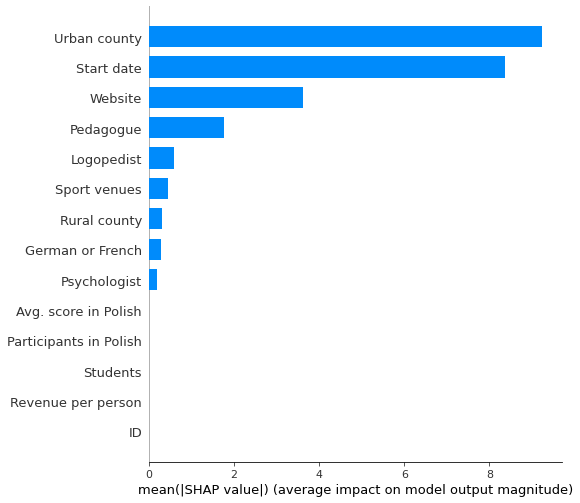

In [18]:
shap.summary_plot(shap_values, test_X.values, plot_type="bar", feature_names=COLUMNS)

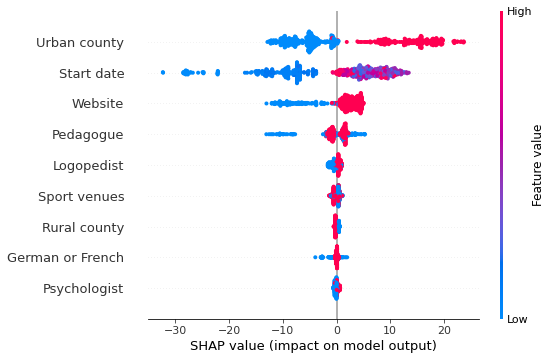

In [21]:
shap.summary_plot(shap_values, test_X.values, feature_names=COLUMNS, max_display=9)

In [22]:
predictions = pipeline.predict(test_X.values)
diff = test_y.values.squeeze() - predictions
diff_indices = np.argsort(diff)
diff_indices_neg = diff_indices[:10]
diff_indices_pos = diff_indices[-10:]

In [23]:
pos_examples = test_X.iloc[diff_indices_pos].join(test_y.iloc[diff_indices_pos])
pos_examples["Prediction"] = predictions[diff_indices_pos]
pos_examples

,ID,Rural county,Urban county,Revenue per person,Website,Start date,Students,Sport venues,German or French,Logopedist,Psychologist,Pedagogue,Participants in Polish,Avg. score in Polish,Prctl in Polish,Prediction
3282,3282,1,0,0.025345,1,0.054795,0.098627,1,1,1,0,1,0.033473,69,90.685898,27.342768
3524,3524,0,1,0.015653,0,0.063927,0.248439,1,1,0,0,0,0.142259,67,85.146540,21.744827
6510,6510,1,0,0.050329,1,0.047945,0.092385,0,1,1,1,1,0.037657,72,95.734234,32.065393
3022,3022,0,1,0.094591,1,0.047945,0.234082,1,1,1,1,1,0.129707,69,90.685898,26.712489
5586,5586,1,0,0.050082,1,0.054795,0.235955,1,1,1,0,1,0.121339,68,88.322848,20.150186
5474,5474,1,0,0.076947,1,0.057078,0.064295,1,1,0,1,1,0.041841,66,81.847476,13.368351
4849,4849,0,1,0.056867,1,0.047945,0.143571,1,1,1,0,1,0.054393,79,99.601043,30.975668
3458,3458,0,1,0.072163,1,0.123288,0.240325,1,1,1,1,1,0.146444,73,96.885070,27.951112
2843,2843,0,1,0.103880,1,0.098174,0.120474,1,1,0,0,0,0.016736,75,98.296762,23.641113
3390,3390,0,1,0.037732,0,0.171233,0.145443,1,1,1,0,1,0.054393,75,98.296762,20.780058


In [24]:
neg_examples = test_X.iloc[diff_indices_neg].join(test_y.iloc[diff_indices_neg])
neg_examples["Prediction"] = predictions[diff_indices_neg]
neg_examples

,ID,Rural county,Urban county,Revenue per person,Website,Start date,Students,Sport venues,German or French,Logopedist,Psychologist,Pedagogue,Participants in Polish,Avg. score in Polish,Prctl in Polish,Prediction
6221,6221,1,0,0.235169,1,0.047945,0.241573,1,1,1,0,1,0.146444,48,7.948443,75.500755
5358,5358,0,1,0.179526,1,0.212329,0.373283,0,1,0,0,1,0.255230,53,21.052632,87.184270
3512,3512,0,1,0.042203,1,0.264840,0.094881,0,1,0,0,1,0.020921,41,1.350315,64.246212
5205,5205,0,1,0.127314,1,0.059361,0.387640,1,1,0,0,1,0.263598,49,10.050637,70.702704
1703,1703,0,1,0.228558,1,0.226027,0.280899,1,0,1,0,1,0.117155,48,7.948443,66.733960
5656,5656,1,0,0.128023,0,0.273973,0.144819,0,1,0,0,0,0.046025,42,1.703238,56.941164
6348,6348,1,0,0.313102,1,0.123288,0.090512,1,1,1,0,1,0.000000,43,2.378395,54.895487
2282,2282,1,0,0.053457,0,0.084475,0.088015,1,0,1,0,1,0.012552,45,3.882154,55.808000
5372,5372,0,1,0.156216,0,0.086758,0.254682,0,1,1,1,1,0.104603,45,3.882154,52.865905
4882,4882,1,0,0.026326,1,0.353881,0.071785,1,1,1,0,0,0.012552,49,10.050637,57.371405


<a id="summary_and_next_steps"></a>
# Summary and next steps
You successfully completed this notebook!
You learned how to use AutoAI pipeline definition to train the model.
Check out our [Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai) for more samples, tutorials, documentation, how-tos, and blog posts.

<a id="copyrights"></a>
### Copyrights

Licensed Materials - Copyright © 2022 IBM. This notebook and its source code are released under the terms of the ILAN License. Use, duplication disclosure restricted by GSA ADP Schedule Contract with IBM Corp.

**Note:** The auto-generated notebooks are subject to the International License Agreement for Non-Warranted Programs (or equivalent) and License Information document for Watson Studio Auto-generated Notebook (License Terms), such agreements located in the link below. Specifically, the Source Components and Sample Materials clause included in the License Information document for Watson Studio Auto-generated Notebook applies to the auto-generated notebooks.  

By downloading, copying, accessing, or otherwise using the materials, you agree to the <a href="http://www14.software.ibm.com/cgi-bin/weblap/lap.pl?li_formnum=L-AMCU-BYC7LF">License Terms</a>

___